## Notebook for synthetic modelling of CUBO
Code steps: 
- import pygimli packages
- create geometry + mesh
- run fwd model (homogeneous of 1 Ohm.m)
- create mesh with central anomaly and define anomaly resistivity
- run fwd model with anomaly
- invert and plot

In [1]:
import pybert as pb
import pygimli as pg
import numpy as np
from pygimli.physics.ert import ERTManager, createGeometricFactors
import pygimli.meshtools as mt
from pygimli.viewer.pv import drawSensors
from pygimli.physics.ert import simulate as simulateERT
from pygimli.viewer.pv import drawStreamLines, drawSlice

In [2]:
# Put the current folder (if needed)
#import os 
#main= ?
#os.chdir(main)
import os 
os.getcwd()

'E:\\Padova\\ZZ_Colleagues\\ZZ_Alberto\\geothermal-lab-ERT'

### load real dataset just to pick up the skip0 scheme to reproduce

In [3]:
elecs_raw = np.genfromtxt('synthetic/elecsXYZ.csv', delimiter=",",skip_header=1)
inputfileERT = 'synthetic/3d_data_test.data'
dataERT = pb.load(inputfileERT) # pick up the skip0 scheme to reproduce

05/03/21 - 12:46:50 - pyGIMLi - INFO - imported:  Data: Electrodes: 48 data: 2194


### create mesh
- change mesh extension if needed (currently cube of 110cm)

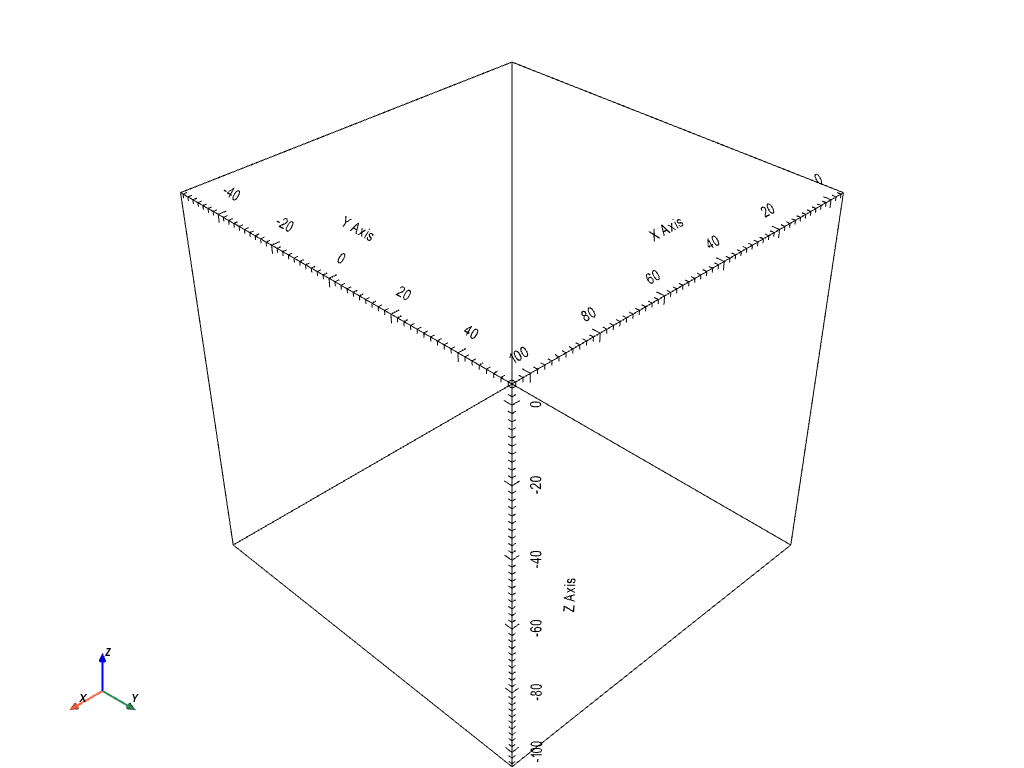

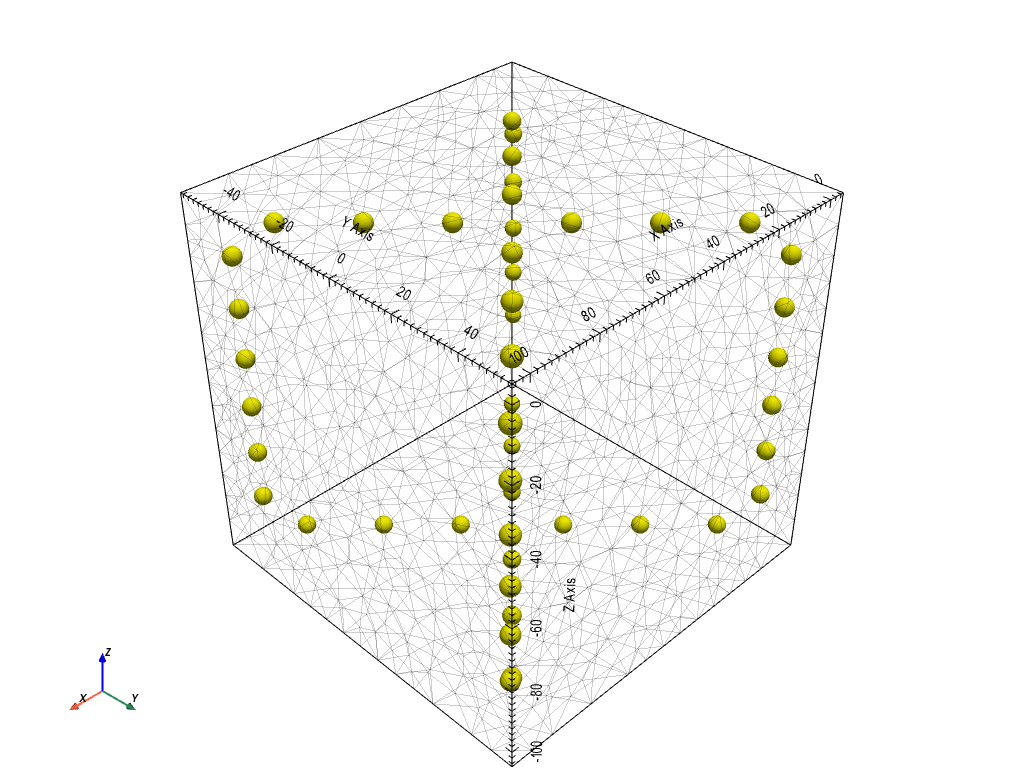

[(262.5036817835951, 212.50368178359506, 162.50368178359506),
 (50.0, 0.0, -50.0),
 (0.0, 0.0, 1.0)]

In [4]:
plc = mt.createCube(size=[110, 110, 110], pos=[50,0,-50], boundaryMarker=1)

for s in dataERT.sensors():
    plc.createNode(s, marker=-99)
pg.show(plc,notebook=True)

plc.createNode([min(elecs_raw[:,0]), min(elecs_raw[:,0]), -80], marker=-999)
plc.createNode([max(elecs_raw[:,0]), min(elecs_raw[:,0]), -20], marker=-1000)

for s in plc.positions(pg.find(plc.nodeMarkers() == -99)):
    plc.createNode(s - [0.0, 0.0, -1e-3/2])
    
    
# Also refine the reference node
for s in plc.positions(pg.find(plc.nodeMarkers() == -999)):
    plc.createNode(s - [0.0, 0.0, -1e-3/2])
for s in plc.positions(pg.find(plc.nodeMarkers() == -1000)):
    plc.createNode(s - [0.0, 0.0, -1e-3/2])
    
mesh = mt.createMesh(plc,quality=34,area=200)
mesh.save('synthetic/mesh_inv.bms')
mesh.exportVTK('synthetic/mesh_inv.vtk')

plotter, _ = pg.show(mesh, alpha=0.1, hold=True,notebook=True)
drawSensors(plotter,  dataERT.sensors(), diam=5, color='yellow')
plotter.show()

In [5]:
### Run homogeneous model to get the geometrical factor K

In [6]:
hom = simulateERT(mesh, res=1.0, scheme=dataERT, sr=False,
                  calcOnly=True, verbose=True)

hom.save('synthetic/homogeneous.ohm', 'a b m n u i')

1

## Build a new mesh with an anomaly

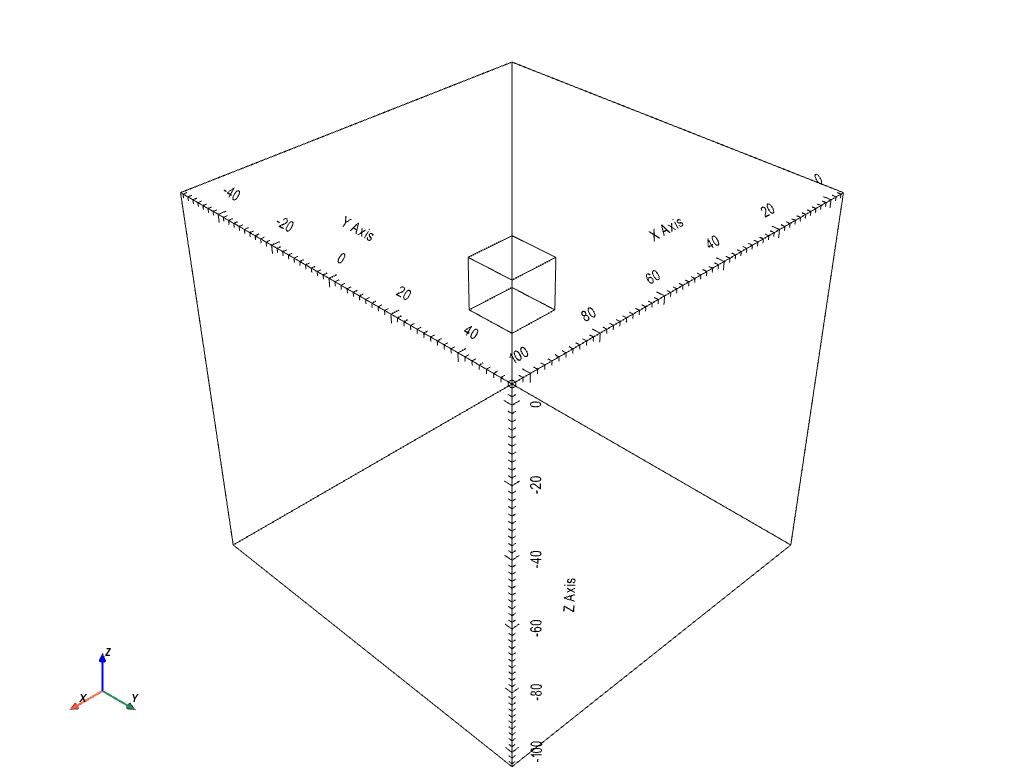

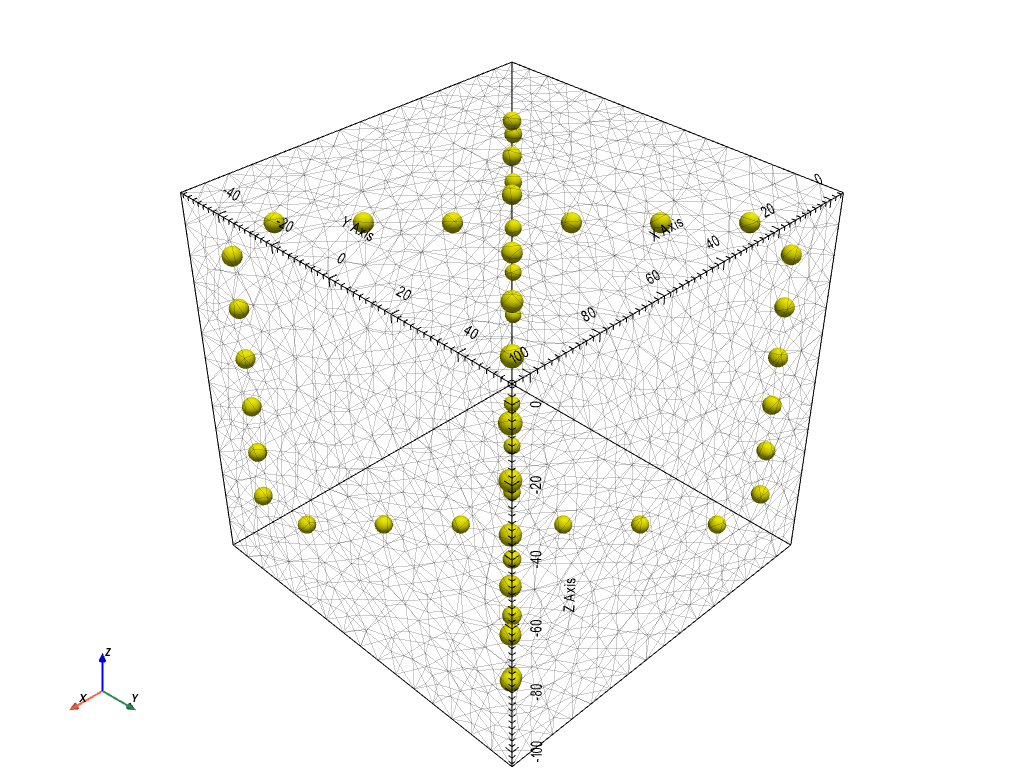

[(262.5036817835951, 212.50368178359506, 162.50368178359506),
 (50.0, 0.0, -50.0),
 (0.0, 0.0, 1.0)]

In [7]:
cube = mt.createCube(size=[15, 15, 15], pos=[50, 0, -20], marker=2, area=5)
plc += cube
pg.show(plc, notebook=True)

mesh_fwd = mt.createMesh(plc,quality=34,area=100)
mesh.save('synthetic/mesh_fwd.bms')
mesh_fwd.exportVTK('synthetic/mesh_fwd.vtk')

plotter, _ = pg.show(mesh_fwd, alpha=0.1, hold=True,notebook=True)
drawSensors(plotter,  dataERT.sensors(), diam=5, color='yellow')
plotter.show()

### Define resistivity map for anomaly and surrounding soil

05/03/21 - 12:47:14 - pyGIMLi - INFO - Calculate geometric factors.


relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100
Data error estimate (min:max)  0.010000072846983609 : 0.010231727514952044


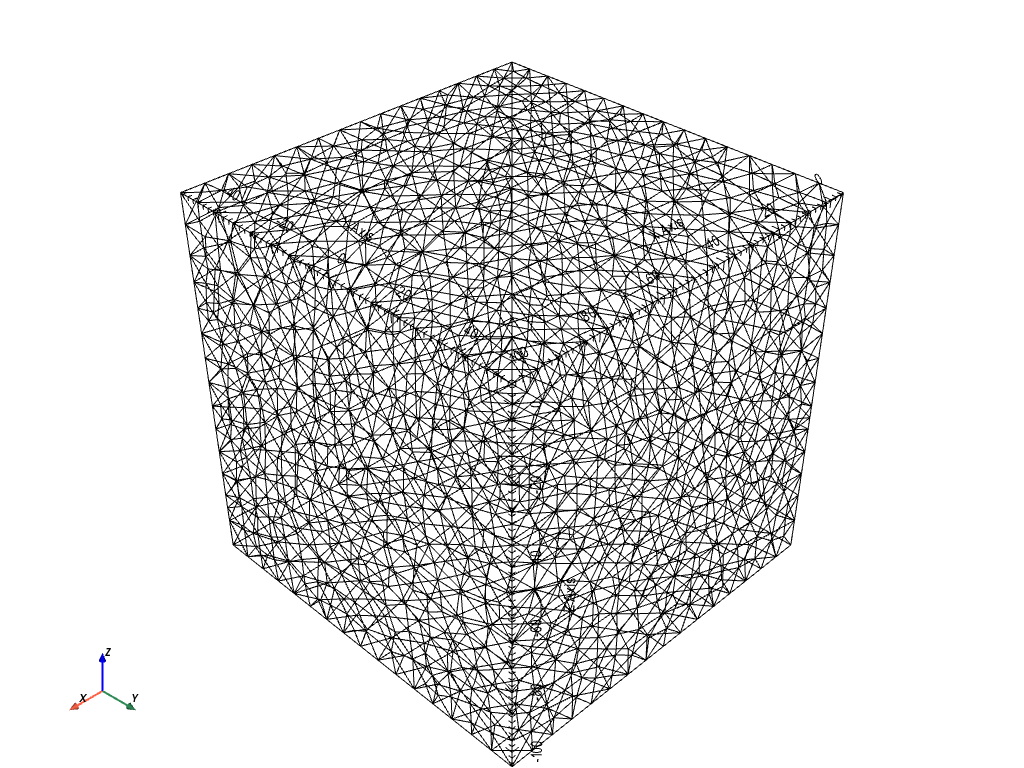

1

In [8]:
res = [[1, 1000.0], [2, 10.0]]  # map markers 1 and 2 to 10 and 100 Ohmm, resp.
het = simulateERT(mesh_fwd, res=res, scheme=dataERT, sr=False,
                  calcOnly=False, verbose=True, noiseLevel=1,
                    noiseAbs=1e-6, seed=1337)
pg.show(mesh_fwd, notebook=True)
het.save('synthetic/simulated.dat')

### here you can even consider a lower relativeError to better fit your data

In [ ]:
ert = pg.physics.ERTManager()  # sr=False, verbose=True, debug=False)

het['err'] = ert.estimateError(het, 
                                   absoluteError=0.001, 
                                   relativeError=0.05)
dataERT.markInvalid(dataERT("rhoa") < 0)
dataERT.removeInvalid()
dataERT.save('synthetic/dataERT.data')
# ert.setMesh(mesh)  

model = ert.invert(data=het, mesh=mesh,lam=20,verbose=True)
pg.info('Inversion stopped with chi² = {0:.3}'.format(ert.fw.chi2()))

05/03/21 - 12:47:22 - pyGIMLi - INFO - Found 1 regions.
05/03/21 - 12:47:22 - pyGIMLi - INFO - Creating forward mesh from region infos.
05/03/21 - 12:47:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
05/03/21 - 12:47:39 - pyGIMLi - INFO - Starting inversion.
05/03/21 - 12:47:39 - pyGIMLi - INFO - Set default startmodel to median(data values)=994.5173829348062


In [ ]:
rhomap = pg.solver.parseMapToCellArray(res, mesh_fwd) # dict does not work
plotter, _ = pg.show(mesh_fwd, alpha=0.1, hold=True,notebook=True)
drawSlice(plotter, mesh_fwd, normal=[0,1,0], data=rhomap, label="rhomap")
drawSensors(plotter,  dataERT.sensors(), diam=5, color='yellow')
plotter.show()

plotter, _ = pg.show(mesh, alpha=0.01, data=model, hold=True,notebook=True)
drawSlice(plotter, mesh, normal=[0,1,0], data=model, label="model")
drawSensors(plotter,  dataERT.sensors(), diam=5, color='yellow')
plotter.show()

In [ ]:
cov = ert.coverage()
plotter, _ = pg.show(mesh,alpha=0.1,data=cov, hold=True, 
                      notebook=True)
plotter.show()

mesh.addData('model',model)
mesh.addData('cov',cov)
mesh.exportVTK('synthetic/result_synth.vtk')